In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os, gc, pickle, datetime, lightgbm, math, catboost, xgboost, warnings
from scipy.cluster.hierarchy import dendrogram
from category_encoders.target_encoder import TargetEncoder
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.utils import plot_model
import keras_tuner

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, LassoCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import AgglomerativeClustering
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics


colors = sns.color_palette("Set2")
np.set_printoptions(linewidth=150, edgeitems=5)
from collections import defaultdict
from typing import Any, Dict, Optional, Union
from matplotlib.axes import Axes

In [3]:
result_list = []
train = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/playground-series-s3e13/sample_submission.csv')

print(f"Length of train:          {len(train)}")
print(f"Length of test:           {len(test)}")
print()

print('Sample data from train:')
train.tail(3)

Length of train:          707
Length of test:           303

Sample data from train:


,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
id,,,,,,,,,,,,,,,,,,,,,
704,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
705,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Plague
706,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Tungiasis


Feature Engineering

In [4]:
# Missing values
missing_values_count1 = train.isnull().sum()
total_cells = np.product(train.shape)
total_missing = missing_values_count1.sum()
percent_missing1 = (total_missing/total_cells) * 100
percent_missing1

0.0

In [5]:
missing_values_count2 = test.isnull().sum()
total_cells = np.product(test.shape)
total_missing = missing_values_count2.sum()
percent_missing2 = (total_missing/total_cells) * 100
percent_missing2

0.0

In [4]:
X = train.drop(['prognosis'], axis = 1)
X

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y = pd.DataFrame(train['prognosis'])
y

,prognosis
id,
0,Lyme_disease
1,Tungiasis
2,Lyme_disease
3,Zika
4,Rift_Valley_fever
...,...
702,Plague
703,Malaria
704,Zika


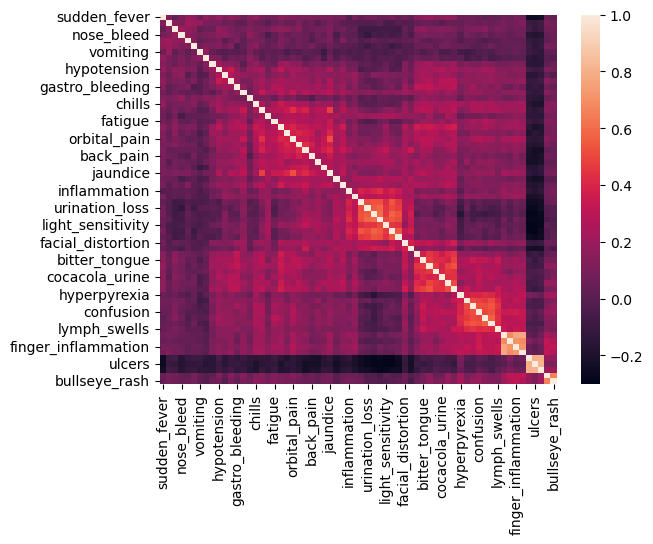

In [8]:
import seaborn as sns
corr_matrix = X.corr()
sns.heatmap(corr_matrix);

In [9]:
#After training find most important features

In [6]:
print("Unique values:")
for f in X:
    print(f"{f:26} {np.unique(X[f])}")

Unique values:
sudden_fever               [0. 1.]
headache                   [0. 1.]
mouth_bleed                [0. 1.]
nose_bleed                 [0. 1.]
muscle_pain                [0. 1.]
joint_pain                 [0. 1.]
vomiting                   [0. 1.]
rash                       [0. 1.]
diarrhea                   [0. 1.]
hypotension                [0. 1.]
pleural_effusion           [0. 1.]
ascites                    [0. 1.]
gastro_bleeding            [0. 1.]
swelling                   [0. 1.]
nausea                     [0. 1.]
chills                     [0. 1.]
myalgia                    [0. 1.]
digestion_trouble          [0. 1.]
fatigue                    [0. 1.]
skin_lesions               [0. 1.]
stomach_pain               [0. 1.]
orbital_pain               [0. 1.]
neck_pain                  [0. 1.]
weakness                   [0. 1.]
back_pain                  [0. 1.]
weight_loss                [0. 1.]
gum_bleed                  [0. 1.]
jaundice                   [0. 1.]
coma 

In [7]:
print(np.unique(y))

['Chikungunya' 'Dengue' 'Japanese_encephalitis' 'Lyme_disease' 'Malaria'
 'Plague' 'Rift_Valley_fever' 'Tungiasis' 'West_Nile_fever' 'Yellow_Fever'
 'Zika']


In [12]:
#LabelEncoder wil do it in this order:
#y['prognosis'].replace(['Chikungunya', 'Dengue', 'Japanese_encephalitis', 'Lyme_disease', 'Malaria', 'Plague', 'Rift_Valley_fever', 'Tungiasis', 'West_Nile_fever', 'Yellow_Fever', 'Zika'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True)


In [10]:
#Use Label encoder:
le = LabelEncoder()
le.fit(train['prognosis'])
y = pd.DataFrame(le.transform(train['prognosis']))

In [11]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [15]:
integerMapping = get_integer_mapping(le)
integerMapping

{'Chikungunya': 0,
 'Dengue': 1,
 'Japanese_encephalitis': 2,
 'Lyme_disease': 3,
 'Malaria': 4,
 'Plague': 5,
 'Rift_Valley_fever': 6,
 'Tungiasis': 7,
 'West_Nile_fever': 8,
 'Yellow_Fever': 9,
 'Zika': 10}

In [12]:
y

,0
0,3
1,7
2,3
3,10
4,6
...,...
702,5
703,4
704,10
705,5


In [17]:
#for metrics - https://www.kaggle.com/code/wendykan/map-k-demo

In [13]:
#XGB test
params = {'objective' : 'multi:softproba',
          "num_class": '11',
          'eval_metric': 'map@3',      
          'reg_alpha': 1, # L1 =1 on default
          'reg_lambda': 0, # L2
          'learning_rate': 0.05, # 
          'max_depth': 2, #  
          'n_estimators': 150 # 
         }
clf = xgb.XGBClassifier(**params, tree_method="exact", booster="dart")

#How to choose map@K - https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
#map@n: n can be assigned as an integer to cut off the top positions in the lists for evaluation.

In [14]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='map@3', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_class='11', num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [20]:
#clf.fit(X, y)
##Optimize with grid search (find the best hyperparameters)
'''
param_grid = {
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': range (2, 10, 2),
    'n_estimators': range(100, 400, 50)
}

#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#‘neg_log_loss’ (negative log-likelihood) -> metrics.log_loss -> requires predict_proba support
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_log_loss', return_train_score=True, verbose=True, n_jobs = 10)
grid_search.fit(X, y)

#Best was found: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}

clf_best_model = grid_search.best_estimator_.fit(X, y)
'''

"\nparam_grid = {\n    'learning_rate': [0.1, 0.01, 0.05],\n    'max_depth': range (2, 10, 2),\n    'n_estimators': range(100, 400, 50)\n}\n\n#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter\n#‘neg_log_loss’ (negative log-likelihood) -> metrics.log_loss -> requires predict_proba support\ngrid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_log_loss', return_train_score=True, verbose=True, n_jobs = 10)\ngrid_search.fit(X, y)\n\n#Best was found: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}\n\nclf_best_model = grid_search.best_estimator_.fit(X, y)\n"

In [21]:
#grid_search.best_estimator_
#grid_search.best_params_
#grid_search.best_score_
#plt.barh(clf.feature_names_in_, clf.feature_importances_)

In [15]:
#Result in dataframe
y_pred = clf.predict_proba(test)
y_pred = pd.DataFrame(y_pred)
y_pred

,0,1,2,3,4,5,6,7,8,9,10
0,0.154332,0.182281,0.080502,0.018176,0.008078,0.044038,0.181179,0.102186,0.083233,0.032255,0.113741
1,0.162537,0.231742,0.094441,0.010676,0.074409,0.035871,0.117725,0.052805,0.131198,0.051031,0.037565
2,0.030499,0.013688,0.139332,0.029785,0.056838,0.075334,0.104535,0.072230,0.253313,0.136144,0.088303
3,0.105447,0.101811,0.219267,0.016879,0.039382,0.081502,0.154078,0.038809,0.043428,0.095410,0.103987
4,0.011960,0.020407,0.238984,0.059535,0.107012,0.138888,0.052469,0.025153,0.161690,0.086834,0.097067
...,...,...,...,...,...,...,...,...,...,...,...
298,0.020572,0.006581,0.118984,0.025896,0.036392,0.110101,0.046840,0.117479,0.199330,0.152836,0.164987
299,0.003830,0.011253,0.029785,0.401664,0.268178,0.147043,0.032117,0.009101,0.047501,0.028647,0.020882
300,0.019609,0.029928,0.083183,0.588875,0.058000,0.046056,0.029703,0.015265,0.101743,0.016777,0.010861
301,0.021554,0.134719,0.075145,0.072320,0.014496,0.065033,0.079879,0.024217,0.267173,0.067207,0.178256


#Transforming for result

In [16]:
def top_3(arr): 
    n = arr.shape[0]
    out = np.zeros((n, 3))
    for i in range(0, n):
        out[i, ] = arr[i,].argsort()[::-1][:3]
    return out

In [17]:
#result in array
clf.predict_proba(test)

array([[0.15433152, 0.18228056, 0.08050225, 0.01817576, 0.00807776, ..., 0.18117906, 0.10218615, 0.08323324, 0.03225526, 0.11374069],
       [0.16253744, 0.2317422 , 0.09444135, 0.01067578, 0.07440858, ..., 0.11772474, 0.05280457, 0.13119817, 0.05103131, 0.03756497],
       [0.03049856, 0.01368757, 0.13933183, 0.02978517, 0.05683842, ..., 0.1045351 , 0.07222991, 0.25331298, 0.13614398, 0.08830287],
       [0.1054473 , 0.10181054, 0.21926653, 0.01687915, 0.03938203, ..., 0.15407817, 0.0388086 , 0.04342783, 0.09540998, 0.10398747],
       [0.01195998, 0.02040721, 0.23898405, 0.05953452, 0.10701217, ..., 0.05246938, 0.02515308, 0.16169007, 0.08683385, 0.09706747],
       ...,
       [0.0205719 , 0.00658149, 0.11898448, 0.02589607, 0.03639193, ..., 0.04683995, 0.11747929, 0.19933018, 0.15283597, 0.16498736],
       [0.00382994, 0.01125272, 0.02978515, 0.40166372, 0.26817793, ..., 0.03211723, 0.00910113, 0.04750086, 0.02864695, 0.02088163],
       [0.01960919, 0.02992794, 0.08318256, 0.5888

In [18]:
top_3_prediction_test = top_3(clf.predict_proba(test)).astype('int32')

In [19]:
top_3_prediction_test 

array([[ 1,  6,  0],
       [ 1,  0,  8],
       [ 8,  2,  9],
       [ 2,  6,  0],
       [ 2,  8,  5],
       [10,  9,  8],
       [ 2,  4,  5],
       [ 0,  1,  7],
       [ 9,  2, 10],
       [ 5,  9, 10],
       [ 8,  9,  2],
       [ 6,  2,  8],
       [ 6,  8,  2],
       [ 0,  1,  6],
       [ 8,  5, 10],
       [ 2,  9, 10],
       [ 8, 10,  5],
       [ 7,  1,  6],
       [ 6,  1,  2],
       [ 3,  8,  5],
       [ 4,  8,  5],
       [ 9,  8, 10],
       [ 5,  2,  4],
       [ 4,  3,  8],
       [ 6,  0,  8],
       [ 0,  1,  6],
       [ 2,  6,  0],
       [ 8,  5,  2],
       [10,  9,  6],
       [ 8,  3,  2],
       [10,  6,  5],
       [ 7,  1,  6],
       [ 3,  6,  4],
       [10,  3,  2],
       [ 3,  4,  5],
       [ 8,  2,  3],
       [10,  0,  9],
       [ 2,  9,  8],
       [ 3,  5,  1],
       [ 8,  3,  2],
       [ 3,  8, 10],
       [ 0,  1,  6],
       [ 9, 10,  5],
       [10,  8,  9],
       [ 0,  1,  8],
       [ 8,  6,  3],
       [ 0,  1,  6],
       [ 3,  

In [23]:
#Back transforming
top_3_predictions = le.inverse_transform(top_3_prediction_test.reshape(-1, 1))

In [24]:
top_3_predictions

array(['Dengue', 'Rift_Valley_fever', 'Chikungunya', 'Dengue', 'Chikungunya', 'West_Nile_fever', 'West_Nile_fever', 'Japanese_encephalitis',
       'Yellow_Fever', 'Japanese_encephalitis', 'Rift_Valley_fever', 'Chikungunya', 'Japanese_encephalitis', 'West_Nile_fever', 'Plague', 'Zika',
       'Yellow_Fever', 'West_Nile_fever', 'Japanese_encephalitis', 'Malaria', 'Plague', 'Chikungunya', 'Dengue', 'Tungiasis', 'Yellow_Fever',
       'Japanese_encephalitis', 'Zika', 'Plague', 'Yellow_Fever', 'Zika', 'West_Nile_fever', 'Yellow_Fever', 'Japanese_encephalitis',
       'Rift_Valley_fever', 'Japanese_encephalitis', 'West_Nile_fever', 'Rift_Valley_fever', 'West_Nile_fever', 'Japanese_encephalitis',
       'Chikungunya', 'Dengue', 'Rift_Valley_fever', 'West_Nile_fever', 'Plague', 'Zika', 'Japanese_encephalitis', 'Yellow_Fever', 'Zika',
       'West_Nile_fever', 'Zika', 'Plague', 'Tungiasis', 'Dengue', 'Rift_Valley_fever', 'Rift_Valley_fever', 'Dengue', 'Japanese_encephalitis',
       'Lyme_dise

In [25]:
#solves this - ValueError: Length of values (909) does not match length of index (303)
test_shape = top_3_prediction_test.shape
top_3_predictions = top_3_predictions.reshape(test_shape)

In [26]:
top_3_predictions

array([['Dengue', 'Rift_Valley_fever', 'Chikungunya'],
       ['Dengue', 'Chikungunya', 'West_Nile_fever'],
       ['West_Nile_fever', 'Japanese_encephalitis', 'Yellow_Fever'],
       ['Japanese_encephalitis', 'Rift_Valley_fever', 'Chikungunya'],
       ['Japanese_encephalitis', 'West_Nile_fever', 'Plague'],
       ['Zika', 'Yellow_Fever', 'West_Nile_fever'],
       ['Japanese_encephalitis', 'Malaria', 'Plague'],
       ['Chikungunya', 'Dengue', 'Tungiasis'],
       ['Yellow_Fever', 'Japanese_encephalitis', 'Zika'],
       ['Plague', 'Yellow_Fever', 'Zika'],
       ['West_Nile_fever', 'Yellow_Fever', 'Japanese_encephalitis'],
       ['Rift_Valley_fever', 'Japanese_encephalitis', 'West_Nile_fever'],
       ['Rift_Valley_fever', 'West_Nile_fever', 'Japanese_encephalitis'],
       ['Chikungunya', 'Dengue', 'Rift_Valley_fever'],
       ['West_Nile_fever', 'Plague', 'Zika'],
       ['Japanese_encephalitis', 'Yellow_Fever', 'Zika'],
       ['West_Nile_fever', 'Zika', 'Plague'],
       ['Tung

In [27]:
submission['prognosis'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

,id,prognosis
0,707,Dengue Rift_Valley_fever Chikungunya
1,708,Dengue Chikungunya West_Nile_fever
2,709,West_Nile_fever Japanese_encephalitis Yellow_F...
3,710,Japanese_encephalitis Rift_Valley_fever Chikun...
4,711,Japanese_encephalitis West_Nile_fever Plague
5,712,Zika Yellow_Fever West_Nile_fever
6,713,Japanese_encephalitis Malaria Plague
7,714,Chikungunya Dengue Tungiasis
8,715,Yellow_Fever Japanese_encephalitis Zika
9,716,Plague Yellow_Fever Zika


In [28]:
submission.to_csv('submission.csv', index = False)

In [ ]:
test_shape